# Demo for Anomaly Detection on the PenDigits data set using Randomized Signature as Feature

In [1]:
import numpy as np
import pandas as pd
import util
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from RandomSignature import *
import sklearn.metrics
import sklearn.preprocessing
import time
from mpl_toolkits import mplot3d

### Loading the data set:

In [2]:
data = {'train': util.load_pendigits_dataset('../Data/pendigits-orig.tra'),
        'test': util.load_pendigits_dataset('../Data/pendigits-orig.tes')}

dataframes = []
for subset, data in data.items():
    df = pd.DataFrame(data).T
    df.columns = ['Stream', 'Digit']
    df['Subset'] = subset
    dataframes.append(df)
df = pd.concat(dataframes)

### Inspecting the data set

                                              Stream Digit Subset
0  [[267.0, 333.0], [267.0, 336.0], [267.0, 339.0...     8  train
1  [[249.0, 234.0], [249.0, 235.0], [251.0, 238.0...     2  train
2  [[196.0, 228.0], [193.0, 222.0], [191.0, 218.0...     1  train
3  [[231.0, 309.0], [232.0, 314.0], [232.0, 318.0...     4  train
4  [[200.0, 273.0], [200.0, 273.0], [199.0, 271.0...     1  train


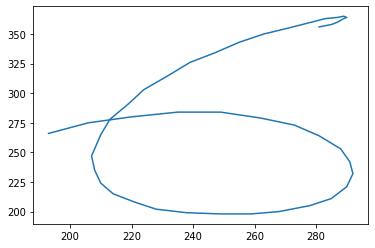

In [3]:
print(df.head())
# df.shape: (10992, 3)
# df.columns: ['Stream', 'Digit', 'Subset']

digit_toplot = 6
df_digit = df[df['Digit'] == digit_toplot]

sample_path = df_digit['Stream'].sample(n=1).to_numpy()[0]

plt.plot(sample_path[:,0],sample_path[:,1])

### Train and evaluate different models 

In [4]:
# fix seed for reproducibility:
np.random.seed(0)
# extract the paths in numpy
paths = df['Stream'].to_numpy()

# normalize each path indiviually
normalized_paths = [sklearn.preprocessing.MinMaxScaler().fit_transform(path) for path in paths]
paths = normalized_paths

# define hyperparameters for the randomized Signature
def identity(x):
    return x

hyperparams_dict = {
'varA':1,
'mean':0,
'res_size':10,
'activation': identity
}

# compute the randomized Signature
Sigs = get_signature(paths,hparams = hyperparams_dict)

# batch of hyperparas_dict['res_size']-dim feature vectors 
# print(Sigs)

# define different possible anomaly detector
clf_IF = [IsolationForest(max_samples = 100),'Isolation Forest']
clf_OCSVM = [OneClassSVM(kernel = 'rbf', nu = 0.1), 'One Class SVM']

#### change here to repeat the analysis with different classifier
clf = clf_OCSVM
####
print('Method used: ', clf[1], '\n')
_,_,_,_ = evaluate_over_digits(Sigs,df,clf[0],verbose = 'True')

Method used:  One Class SVM 

Accuracy for digit  0 :  0.982275586049171
ROC AUC for digit  0 :  0.9977627514817597 

Accuracy for digit  1 :  0.7704402515723271
ROC AUC for digit  1 :  0.8536224464750309 

Accuracy for digit  2 :  0.8962264150943396
ROC AUC for digit  2 :  0.945671192241071 

Accuracy for digit  3 :  0.9576901086335049
ROC AUC for digit  3 :  0.9836507183518569 

Accuracy for digit  4 :  0.9745568896512292
ROC AUC for digit  4 :  0.9873971752561415 

Accuracy for digit  5 :  0.8516295025728988
ROC AUC for digit  5 :  0.9111159347115197 

Accuracy for digit  6 :  0.9636935391652373
ROC AUC for digit  6 :  0.9863144182404143 

Accuracy for digit  7 :  0.8793596340766152
ROC AUC for digit  7 :  0.930427182900061 

Accuracy for digit  8 :  0.9854202401372213
ROC AUC for digit  8 :  0.9968609755730249 

Accuracy for digit  9 :  0.7624356775300172
ROC AUC for digit  9 :  0.873223886328725 

Mean accuracy:  0.9023727844482561
Mean ROC AUC:  0.9466046681559606


### Test the effect of increasing reservoir dimension

In [5]:
# chosen to match the dimension of the (true) Signature used in Anomaly detection on streamed data, Cochrane et al.
res_sizes = [3,7,15,31,63]

t0 = time.time()

print('Method used: ', clf[1], '\n')
for dim in res_sizes:
    hyperparams_dict['res_size'] = dim
    Sigs = get_signature(paths,hparams = hyperparams_dict)
    mean_accuracy,mean_ROC_AUC,digits_accuracy,digits_ROC_AUC = evaluate_over_digits(Sigs,df,clf[0])
    print('Reservoir Size: ', dim)
    print('Mean Accuracy: ', mean_accuracy)
    print('Mean ROC AUC: ', mean_ROC_AUC)
    print('\n')

print('Time needed: ',time.time()-t0)



Method used:  One Class SVM 

Reservoir Size:  3
Mean Accuracy:  0.8602344196683818
Mean ROC AUC:  0.9215019336575041


Reservoir Size:  7
Mean Accuracy:  0.8710120068610636
Mean ROC AUC:  0.9247590736970575


Reservoir Size:  15
Mean Accuracy:  0.9038307604345339
Mean ROC AUC:  0.951987440735118


Reservoir Size:  31
Mean Accuracy:  0.9069468267581475
Mean ROC AUC:  0.9486937896485605


Reservoir Size:  63
Mean Accuracy:  0.9034019439679815
Mean ROC AUC:  0.9459942664938953


Time needed:  14.562827587127686


### We can visualize the randomized Signature when the dimension is 3

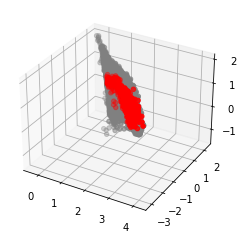

In [6]:
#uncomment for interactive 3d plot
#%matplotlib notebook

hyperparams_dict['res_size'] = 3
Sigs_3d = get_signature(paths,hparams = hyperparams_dict)

test_digit = 1
index_test = df['Digit']==test_digit

fig = plt.figure()
ax = plt.axes(projection='3d')

## all classes different color
#ax.scatter3D(Sigs_3d[:,0],Sigs_3d[:,1],Sigs_3d[:,2], c = df['Digit'])

## one v all
ax.scatter3D(Sigs_3d[index_test,0],Sigs_3d[index_test,1],Sigs_3d[index_test,2], c = 'red')
ax.scatter3D(Sigs_3d[~index_test,0],Sigs_3d[~index_test,1],Sigs_3d[~index_test,2], c = 'grey')

## 5 seem to have multimodal distribution, or maybe some misslabeled instances(?)

### Plotting the ECDF of the Normal vs Anomalous observations

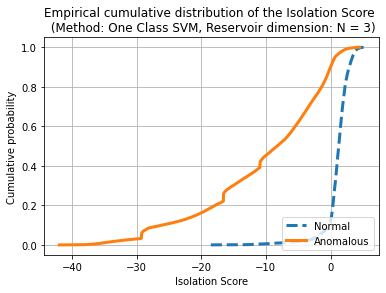

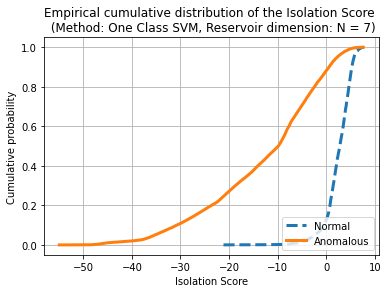

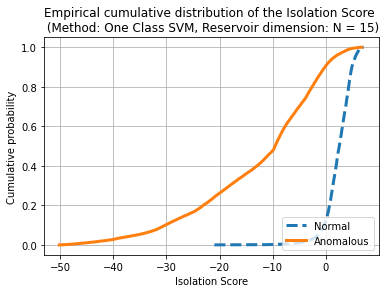

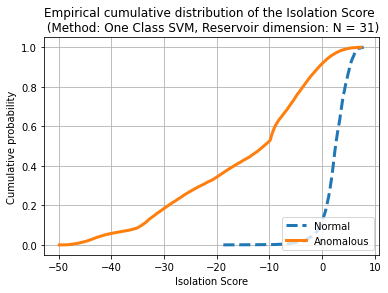

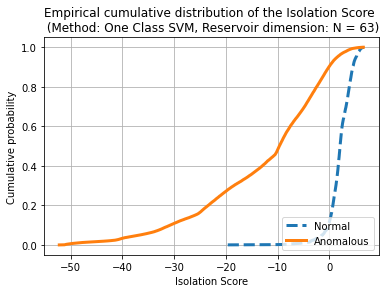

In [7]:
res_sizes = [3,7,15,31,63]
for N in res_sizes:
    hyperparams_dict['res_size'] = N
    plot_score(paths, df, clf, hyperparams_dict)


 ### We can look at how the isolation score evolve while we observe the trajectory

Normal Observations: 

Correctly predicted
Wrongly predicted (False Negative)
Correctly predicted
Correctly predicted
Wrongly predicted (False Negative)

 Anomalous Observation: 

Correctly predicted
Correctly predicted
Correctly predicted
Correctly predicted
Correctly predicted


<Figure size 432x288 with 0 Axes>

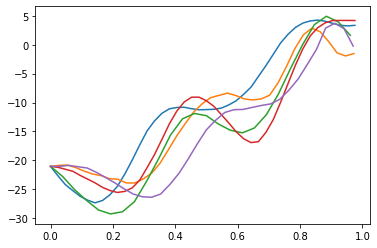

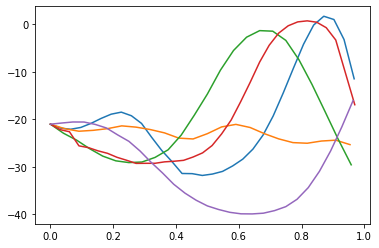

<Figure size 432x288 with 0 Axes>

In [8]:
## compute the whole trajectory for the randomized Signature
Sigs_traj = get_signature(paths, trajectory = True, hparams = hyperparams_dict)

#get the last entry for each trajectory to get the randomized signature at final time
Sigs = np.array([Sigs_traj[i][-1,:] for i in range(Sigs_traj.shape[0])])


digit = 3 #value defining the normal observation
X_train = Sigs[(df['Digit'] == digit) & (df['Subset'] == 'train'),:]

# fit the model (only using the value of the randomized signature at terminal time)
clf[0].fit(X_train)

#sample 5 random trajectory of the normal digit
X_test_digit  = Sigs_traj[(df['Subset']=='test')&(df['Digit'] == digit)]
X_test_digit = X_test_digit[ np.random.randint(0, X_test_digit.shape[0], 5)]

#sample 5 random trajectory of anomalous digits
X_test_other = Sigs_traj[(df['Subset']=='test')&(df['Digit'] != digit)]
X_test_other = X_test_other[ np.random.randint(0, X_test_other.shape[0], 5)]

#compute and plot the evolution of the isolation score along the trajectory of the randomized signature

#normal observations
print('Normal Observations: \n')
for i in range(5):
    isolation_score = [clf[0].decision_function(X_test_digit[i][t].reshape(1,-1)) for t in range(len(X_test_digit[i]))]
    plt.plot(np.array(range(len(X_test_digit[i])))/len(X_test_digit[i]),isolation_score)
    if clf[0].predict(X_test_digit[i][-1].reshape(1,-1)) == [1] :
        print('Correctly predicted')
    else:
        print('Wrongly predicted (False Negative)')
plt.figure()

#anomalous observations
print('\n Anomalous Observation: \n')
for i in range(5):
    isolation_score = [clf[0].decision_function(X_test_other[i][t].reshape(1,-1)) for t in range(len(X_test_other[i]))]
    plt.plot(np.array(range(len(X_test_other[i])))/len(X_test_other[i]),isolation_score)
    if clf[0].predict(X_test_other[i][-1].reshape(1,-1)) == [1] :
        print('Wrongly predicted (False Positive)')
    else:
        print('Correctly predicted')
plt.figure()